# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import pandas as pd
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-13 23:55:03 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-13 23:55:03 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-13 23:55:03 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:55:04 - cmdstanpy - INFO - Chain [1] start processing
2024-11-13 23:55:04 - cmdstanpy - INFO - Chain [1] start processing
23:55:04 - cmdstanpy - INFO - Chain [1] done processing
2024-11-13 23:55:04 - cmdstanpy - INFO - Chain [1] done processing
20

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-13 23:55:04 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-13 23:55:04 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-13 23:55:04 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_45128/3447540174.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
2024-11-13 23:55:04 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-13 23:55:04 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_45128/3447540174.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=54, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

2024-11-13 23:55:04 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-13 23:55:04 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-13 23:55:04 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-13 23:55:04 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-13 23:55:04 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-13 23:55:04 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-13 23:55:04 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-13 23:55:04 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-13 23:55:08 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.06 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-13 23:55:11 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-13 23:55:14 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-13 23:55:17 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-13 23:55:20 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins
2024-11-13 23:55:21 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-13 23:55:21 - robyn.modeling.convergence.converg

Model training complete.


2024-11-13 23:55:22 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer


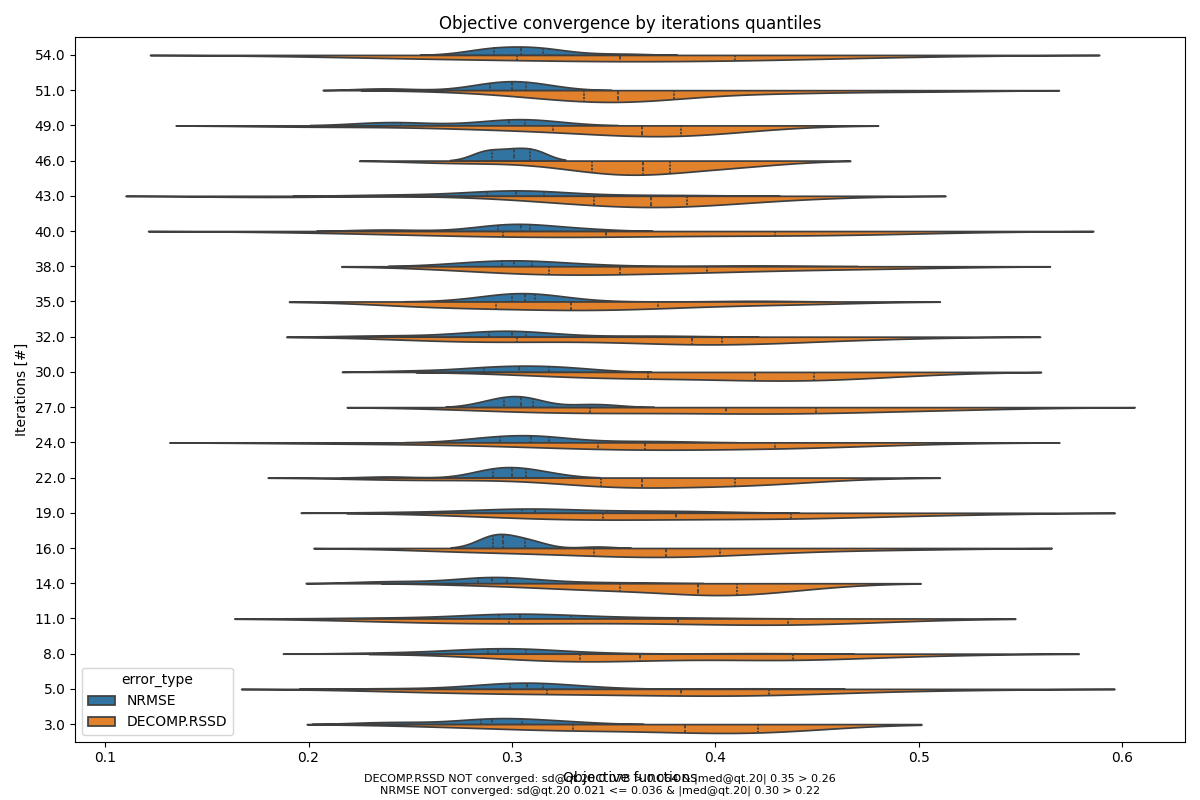

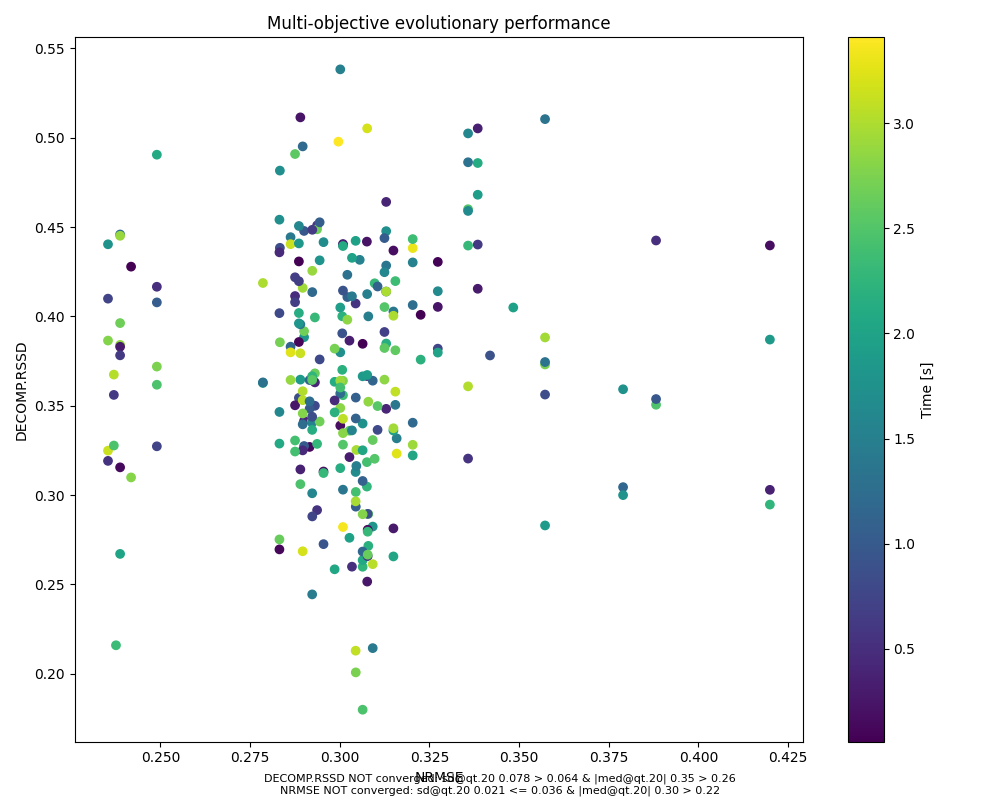

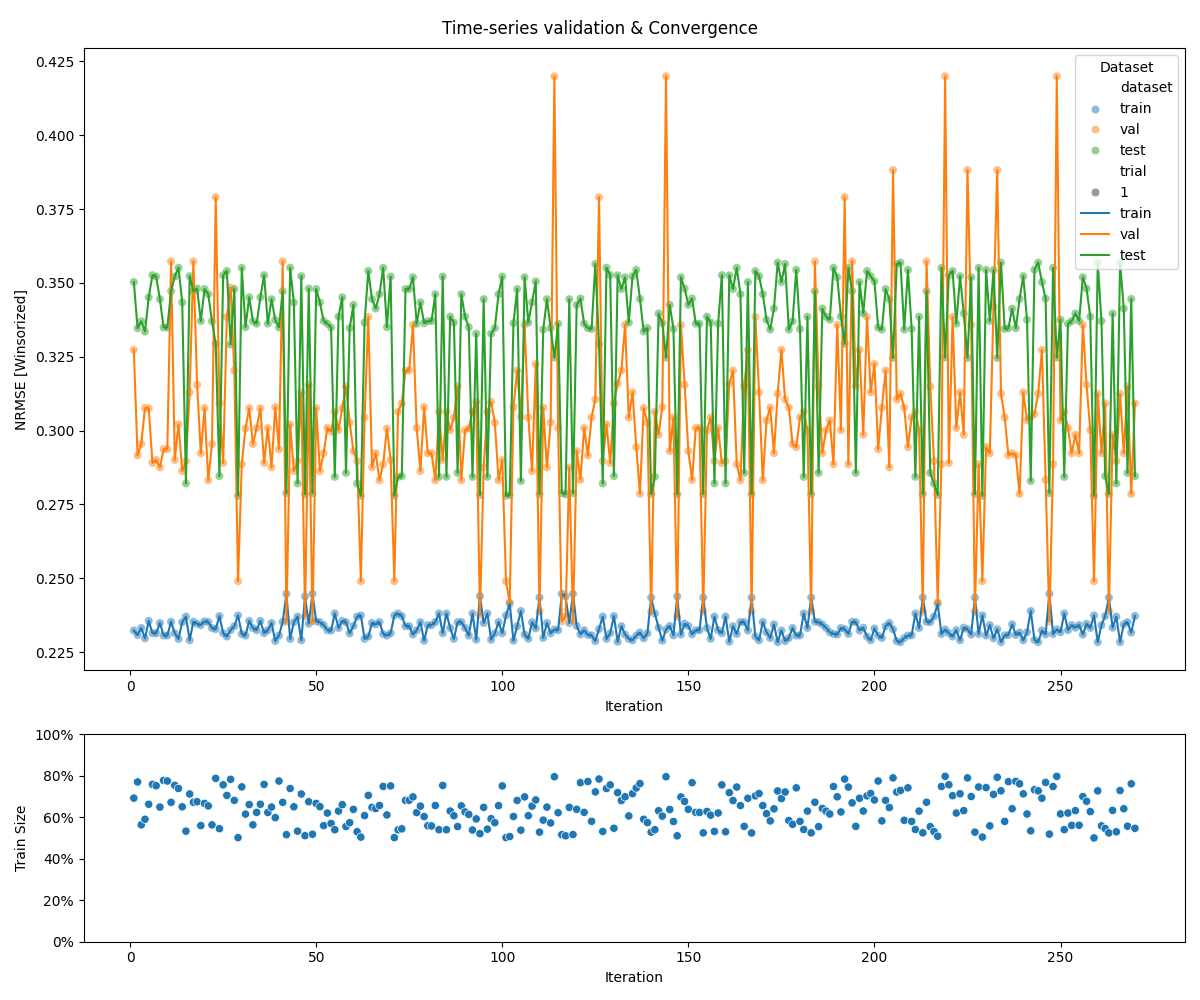

In [10]:
from IPython.display import Image, display
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from robyn.visualization.model_convergence_visualizer import ModelConvergenceVisualizer

model_visualizer = ModelConvergenceVisualizer(
    moo_distrb_plot=output_models.convergence["moo_distrb_plot"],
    ts_validation_plot=output_models.convergence["ts_validation_plot"],
    moo_cloud_plot=output_models.convergence["moo_cloud_plot"],
)

# 1. Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    model_visualizer.display_moo_distrb_plot()

# 2. Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    model_visualizer.display_moo_cloud_plot()

# 3. Display time series validation and convergence plots
if "ts_validation_plot" in output_models.convergence:
    model_visualizer.display_ts_validation_plot()

In [11]:
from utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

Debug: R output data keys: ['trial1', 'trial2', 'trial3', 'trial4', 'trial5']
Data for trial1: Keys = ['resultCollect', 'hyperBoundNG', 'hyperBoundFixed']
Debug: resultCollect keys for trial1: ['resultHypParam', 'xDecompAgg', 'decompSpendDist', 'iter', 'elapsed.min']
Debug: Sample resultHypParam for trial1: [{'facebook_S_alphas': 1.98202923325, 'facebook_S_gammas': 0.58424338159, 'facebook_S_thetas': 0.09072730547999999, 'newsletter_alphas': 1.7514167265, 'newsletter_gammas': 0.6585122811199999, 'newsletter_thetas': 0.22826231587, 'ooh_S_alphas': 1.9350874957500002, 'ooh_S_gammas': 0.80499137605, 'ooh_S_thetas': 0.26847073588000003, 'print_S_alphas': 1.3471347205000002, 'print_S_gammas': 0.6602001640299999, 'print_S_thetas': 0.34398200833000003, 'search_S_alphas': 1.835435262, 'search_S_gammas': 0.6915214566899999, 'search_S_thetas': 0.11253588111, 'tv_S_alphas': 1.71477961025, 'tv_S_gammas': 0.6107644945299999, 'tv_S_thetas': 0.6227415716, 'train_size': 0.61856108114, 'rsq_train': 0.1

In [12]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from dataclasses import is_dataclass, asdict
import pandas as pd


def build_tree(data, parent_key=""):
    """
    Recursively build a tree structure from a dictionary, list, or dataclass.

    Args:
        data: The data structure (dict, list, or dataclass) to traverse.
        parent_key: The base key path for nested keys.

    Returns:
        A tree node representing the structure of the data.
    """
    if is_dataclass(data):
        data = asdict(data)  # Convert dataclass to dictionary

    if isinstance(data, dict):
        node = Node(parent_key)
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            child_node = build_tree(value, full_key)
            child_node.parent = node
        return node
    elif isinstance(data, list):
        node = Node(parent_key)
        for index, item in enumerate(data):
            full_key = f"{parent_key}[{index}]"
            child_node = build_tree(item, full_key)
            child_node.parent = node
        return node
    elif isinstance(data, pd.DataFrame):
        node = Node(f"{parent_key} (DataFrame: {data.shape})")
        return node
    else:
        return Node(parent_key)


# Assuming output_models and r_output_models are instances of ModelOutputs
python_tree = build_tree(output_models)
r_tree = build_tree(r_output_models)

# Visualize the trees
print("Python ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")

print("\nR ModelOutputs Structure:")
for pre, fill, node in RenderTree(r_tree):
    print(f"{pre}{node.name}")

Python ModelOutputs Structure:

├── trials
│   ├── trials[0]
│   │   ├── trials[0].result_hyp_param (DataFrame: (54, 37))
│   │   ├── trials[0].decomp_spend_dist (DataFrame: (270, 34))
│   │   ├── trials[0].x_decomp_agg (DataFrame: (648, 29))
│   │   ├── trials[0].nrmse
│   │   ├── trials[0].decomp_rssd
│   │   ├── trials[0].mape
│   │   ├── trials[0].rsq_train
│   │   ├── trials[0].rsq_val
│   │   ├── trials[0].rsq_test
│   │   ├── trials[0].lambda_
│   │   ├── trials[0].lambda_hp
│   │   ├── trials[0].lambda_max
│   │   ├── trials[0].lambda_min_ratio
│   │   ├── trials[0].pos
│   │   ├── trials[0].nrmse_train
│   │   ├── trials[0].nrmse_val
│   │   ├── trials[0].nrmse_test
│   │   ├── trials[0].elapsed
│   │   ├── trials[0].elapsed_accum
│   │   ├── trials[0].trial
│   │   ├── trials[0].iter_ng
│   │   ├── trials[0].iter_par
│   │   ├── trials[0].train_size
│   │   ├── trials[0].sol_id
│   │   └── trials[0].lift_calibration (DataFrame: (0, 0))
│   ├── trials[1]
│   │   ├── trials[1].

In [13]:
def print_model_outputs_details(model_outputs, label):
    print(f"{label} Trials:")
    for i, trial in enumerate(model_outputs.trials):
        print(f"\nTrial {i} - result_hyp_param Details:")
        print(f"Shape: {trial.result_hyp_param.shape}")
        print("Columns, Data Types, and Nested Structures:")
        for column in trial.result_hyp_param.columns:
            dtype = trial.result_hyp_param[column].dtype
            # Check for nested structures
            first_value = trial.result_hyp_param[column].iloc[0]
            if isinstance(first_value, (list, dict, pd.DataFrame)):
                nested_shape = f" (Nested shape/length: {len(first_value)})"
            else:
                nested_shape = ""
            print(f"  - {column}: {dtype}{nested_shape}")


# Assuming r_output_models and output_models are instances of ModelOutputs
print_model_outputs_details(r_output_models, "R ModelOutputs")
print_model_outputs_details(output_models, "Python ModelOutputs")

R ModelOutputs Trials:

Trial 0 - result_hyp_param Details:
Shape: (54, 39)
Columns, Data Types, and Nested Structures:
  - facebook_S_alphas: float64
  - facebook_S_gammas: float64
  - facebook_S_thetas: float64
  - newsletter_alphas: float64
  - newsletter_gammas: float64
  - newsletter_thetas: float64
  - ooh_S_alphas: float64
  - ooh_S_gammas: float64
  - ooh_S_thetas: float64
  - print_S_alphas: float64
  - print_S_gammas: float64
  - print_S_thetas: float64
  - search_S_alphas: float64
  - search_S_gammas: float64
  - search_S_thetas: float64
  - tv_S_alphas: float64
  - tv_S_gammas: float64
  - tv_S_thetas: float64
  - train_size: float64
  - rsq_train: float64
  - rsq_val: float64
  - rsq_test: float64
  - nrmse_train: float64
  - nrmse_val: float64
  - nrmse_test: float64
  - nrmse: float64
  - decomp.rssd: float64
  - mape: int64
  - lambda: float64
  - lambda_hp: float64
  - lambda_max: float64
  - lambda_min_ratio: float64
  - pos: int64
  - Elapsed: float64
  - ElapsedAccu

In [14]:
import pandas as pd
import numpy as np
from typing import Dict, Any


def compare_model_values(py_output, r_output):
    """Compare key values between Python and R model outputs"""

    print("1. Basic Model Configuration Comparison:")
    basic_attrs = [
        "train_timestamp",
        "cores",
        "iterations",
        "intercept",
        "intercept_sign",
        "nevergrad_algo",
        "ts_validation",
        "add_penalty_factor",
    ]

    # Add debug prints
    print("\nDebugging attribute types:")
    for attr in basic_attrs:
        py_val = getattr(py_output, attr, None)
        r_val = getattr(r_output, attr, None)
        print(f"{attr:20s} - Python type: {type(py_val)} | R type: {type(r_val)}")
        print(f"{attr:20s} - Python value: {py_val} | R value: {r_val}")
        print("-" * 50)

    print("\n2. Trial Results Comparison (Descriptive Statistics):")
    if py_output.trials and r_output.trials:
        metrics = [
            "nrmse",
            "decomp_rssd",
            "mape",
            "rsq_train",
            "rsq_val",
            "rsq_test",
            "lambda_",
            "lambda_hp",
            "lambda_max",
            "lambda_min_ratio",
        ]
        # Convert trial results to DataFrames
        py_trials_df = pd.DataFrame(
            [{metric: getattr(trial, metric, np.nan) for metric in metrics} for trial in py_output.trials]
        )

        # Aggregate R trial metrics
        r_trials_df = pd.DataFrame(
            [
                {metric: getattr(trial, metric, pd.Series([np.nan])).mean() for metric in metrics}
                for trial in r_output.trials
            ]
        )
        # Ensure R trial data is numeric
        r_trials_df = r_trials_df.apply(pd.to_numeric, errors="coerce")
        # Calculate descriptive statistics
        py_desc = py_trials_df.describe()
        r_desc = r_trials_df.describe()
        # Print descriptive statistics
        print("\nPython Trial Descriptive Statistics:")
        print(py_desc)
        print("\nR Trial Descriptive Statistics:")
        print(r_desc)
        # Calculate and print differences
        diff_desc = py_desc - r_desc
        print("\nDifference in Descriptive Statistics:")
        print(diff_desc)

    print("\n3. Hyperparameter Comparison:")
    if hasattr(py_output, "hyper_updated") and hasattr(r_output, "hyper_updated"):
        py_hyper = py_output.hyper_updated
        r_hyper = r_output.hyper_updated

        # Find all unique keys
        all_keys = set(py_hyper.keys()) | set(r_hyper.keys())

        print("\nHyperparameter Values:")
        print(f"{'Parameter':30s} {'Python':>15s} {'R':>15s} {'Diff':>15s}")
        print("-" * 75)

        for key in sorted(all_keys):
            py_val = py_hyper.get(key, "N/A")
            r_val = r_hyper.get(key, "N/A")

            if isinstance(py_val, (int, float)) and isinstance(r_val, (int, float)):
                diff = abs(py_val - r_val)
                print(f"{key:30s} {py_val:15.6f} {r_val:15.6f} {diff:15.6f}")
            else:
                print(f"{key:30s} {str(py_val):15s} {str(r_val):15s} {'N/A':>15s}")

    print("\n4. Data Shape Comparison:")
    data_attrs = ["all_result_hyp_param", "all_x_decomp_agg", "all_decomp_spend_dist"]

    for attr in data_attrs:
        py_shape = getattr(py_output, attr).shape if hasattr(py_output, attr) else None
        r_shape = getattr(r_output, attr).shape if hasattr(r_output, attr) else None
        print(f"{attr:20s} - Python shape: {py_shape} | R shape: {r_shape}")


# Run the comparison
print("Starting detailed value comparison...\n")
compare_model_values(output_models, r_output_models)

Starting detailed value comparison...

1. Basic Model Configuration Comparison:

Debugging attribute types:
train_timestamp      - Python type: <class 'str'> | R type: <class 'str'>
train_timestamp      - Python value: 2024-11-13 23:55:04 | R value: 2024-11-13 05:13:54
--------------------------------------------------
cores                - Python type: <class 'int'> | R type: <class 'int'>
cores                - Python value: 8 | R value: 9
--------------------------------------------------
iterations           - Python type: <class 'int'> | R type: <class 'int'>
iterations           - Python value: 54 | R value: 50
--------------------------------------------------
intercept            - Python type: <class 'bool'> | R type: <class 'bool'>
intercept            - Python value: True | R value: True
--------------------------------------------------
intercept_sign       - Python type: <class 'str'> | R type: <class 'str'>
intercept_sign       - Python value: non_negative | R value: non